### 2. ML modeling and Shapley Feature Extraction
- Load structured data and perform exploratory data analysis (EDA).
- Modeling and Feature Extraction. 

In [1]:
import os
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import warnings

warnings.filterwarnings('ignore')
os.environ["KMP_WARNINGS"] = "0"

from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap 

seed = 1234
np.random.seed(seed)
random.seed(seed)

In [2]:
df_pheno = pd.read_csv("../data/brca_pheno.csv")

In [3]:
print("Loading normalized mRNA expressions on TCGA-BRCA GDC samples...")
df_gdc = pd.read_csv("../data/TMP_20230209/BRCA_v12_20210228.tsv", sep="\t")
df_gdc = df_gdc[(~df_gdc.iloc[:, 2:].isna().all(axis=1)) & (~(df_gdc.iloc[:, 2:] == 0).all(axis=1))]
expression_cols = [col for col in df_gdc.columns if 'GEXP' in col]
df_gdc = df_gdc[['BRCA', 'Labels'] + expression_cols]
df_gdc.columns = [col.split(":")[3] if ':' in col else col for col in df_gdc.columns]

if df_gdc.columns.duplicated().any():
    print("Duplicate columns detected in GDC data. Removing duplicates...")
    df_gdc = df_gdc.loc[:, ~df_gdc.columns.duplicated()]

print("Joining grip query result on BRCA subtype's with normalized mRNA expressions...")
df_pheno.rename(columns={"secondary_identifier": "BRCA"}, inplace=True)
df_gdc = df_gdc.merge(df_pheno[['BRCA', 'subtype']], on='BRCA', how='left')
df_gdc.drop('Labels', axis=1, inplace=True)
df_gdc.rename(columns={"subtype": "Labels"}, inplace=True)
df_gdc.index = df_gdc.BRCA
demo_order = ['Labels'] + list(df_gdc.columns[3:10])

Loading normalized mRNA expressions on TCGA-BRCA GDC samples...
Duplicate columns detected in GDC data. Removing duplicates...
Joining grip query result on BRCA subtype's with normalized mRNA expressions...


EDA - Evaluating data distribution...


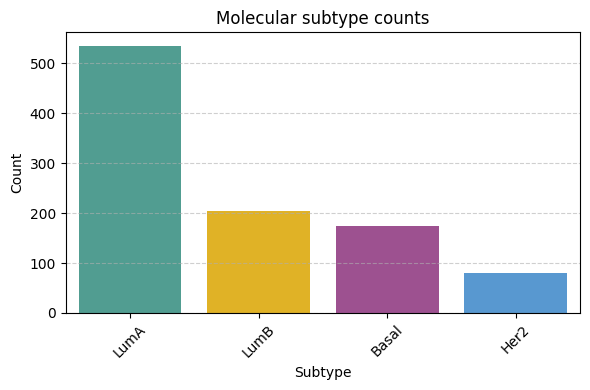

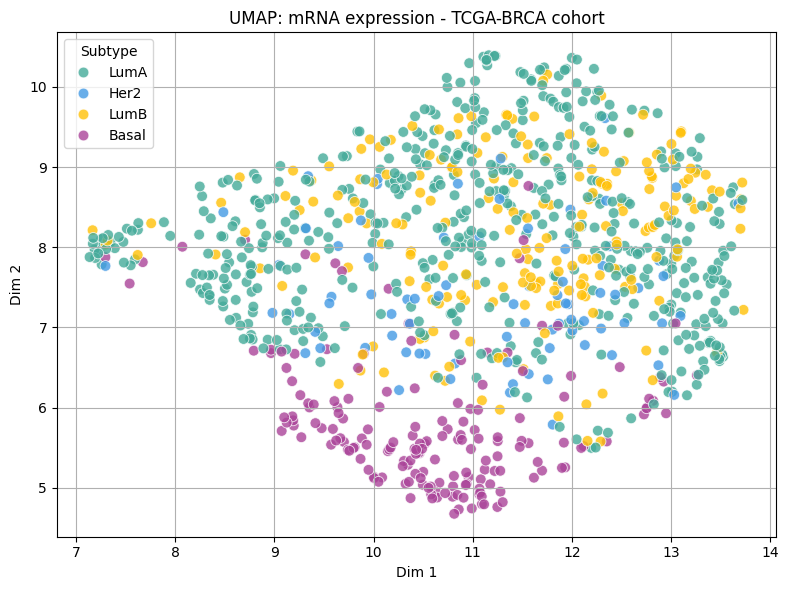

In [4]:
subtype_colors = {
    "LumA": "#44AA99",  
    "LumB": "#FFC107",  
    "Basal": "#AA4499", 
    "Her2": "#449AE4"   
}

print("EDA - Evaluating data distribution...")
count_per_label = df_gdc['Labels'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=count_per_label.index, y=count_per_label.values, palette=[subtype_colors[label] for label in count_per_label.index])
plt.title("Molecular subtype counts", fontsize=12)
plt.xlabel("Subtype", fontsize=10), plt.ylabel("Count", fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# UMAP on TCGA-BRCA normalized scRNA-Seq mRNA expression 
gene_expression_cols = df_gdc.drop(columns=["Labels", "BRCA"]).columns  
df_gdc_scaled = df_gdc[['Labels'] + list(gene_expression_cols)].copy()

scaler = StandardScaler()
df_gdc_scaled[gene_expression_cols] = scaler.fit_transform(df_gdc_scaled[gene_expression_cols])

umap_reducer = umap.UMAP(n_components=2, random_state=seed)
umap_embedding = umap_reducer.fit_transform(df_gdc_scaled[gene_expression_cols])
df_gdc_scaled['UMAP1'] = umap_embedding[:, 0]
df_gdc_scaled['UMAP2'] = umap_embedding[:, 1]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_gdc_scaled, x="UMAP1", y="UMAP2", hue="Labels", palette=subtype_colors, s=60, alpha=0.8)
plt.title("UMAP: mRNA expression - TCGA-BRCA cohort")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Subtype")
plt.grid(True)
plt.tight_layout()
plt.show()

- Luminal A and Luminal B are both classified as hormone receptor-positive (HR+), meaning they express estrogen and progesterone receptors. 
- Luminal A is usually HER2-negative while Luminal B may be HER2-positive, which can impact treatment options. 
- Basal tumors lack estrogen receptors, making them "triple negative" (ER-, PR-, HER2-) while Luminal cancers are typically hormone receptor positive (ER+) and have a better outlook with hormone therapy options.

In [5]:
import shap
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import logging

tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)
# ----------------------------
# data prep
# ----------------------------
# subtype mappings 
class_maps = {0: "LumA", 1: "LumB", 2: "Basal", 3: "Her2"}

# remove unwanted columns
cols_to_drop = [col for col in ["Labels", "BRCA"] if col in df_gdc_scaled.columns]
pca_cols = [col for col in df_gdc_scaled.columns if str(col).startswith("PCA")] 
cols_to_drop.extend(pca_cols)

X_df = df_gdc_scaled.drop(columns=cols_to_drop).apply(pd.to_numeric, errors='coerce').fillna(0)
feature_names = list(X_df.columns)
X = X_df.values  # features (genes - standard ensemble gene names)

y = df_gdc['Labels'].astype('category').cat.codes
y_onehot = to_categorical(y, num_classes=len(class_maps))
X, y_onehot = shuffle(X, y_onehot, random_state=seed)

# ----------------------------
# f1 score function for tensorflow models metrics 
# ----------------------------
@tf.function(reduce_retracing=True)
def tf_f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred) 
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float32'), axis=0)
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float32'), axis=0) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float32'), axis=0) + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)
    
# ----------------------------
# simple tensorflow.keras NN model
# ----------------------------
def create_model(input_shape, num_classes):
    """Simple feed-forward neural network with two hidden layers: 
        - deep layers: fully connected layers with 64 neurons each, using the ReLU activation function.
        - dropout: regularization technique to prevent overfitting by randomly dropping neurons during training.
        - Final layer uses the softmax activation function for multi-class classification (to output probabilities for each class). 
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)), Dropout(0.2), Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf_f1_score])
    return model

# ----------------------------
# cv to examine model performance 
# ----------------------------
k_folds = 10 # max n fold desired 
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

top_N = 50 # number of top features you want per fold
sample_data = X[:len(X)] # fixed sample of data 
fold_accuracies = []
fold_f1 = []
fold_number = 1 # start from fold 1

for train_idx, test_idx in kf.split(X): # split data into training and testing sets 
    print(f"\n ===== Fold {fold_number}/{k_folds} ===== ")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_onehot[train_idx], y_onehot[test_idx]
    
    model = create_model(X.shape[1], len(class_maps)) # create NN model and train
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_test_classes, y_pred_classes)
    test_loss, test_accuracy, test_f1 = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {fold_number} Accuracy: {acc:.4f}, f1-score: {test_f1:.4f}")

    fold_accuracies.append(acc)
    fold_f1.append(test_f1)
    fold_number += 1 # move to next fold

mean_acc = np.mean(fold_accuracies)
std_acc = np.std(fold_accuracies)
mean_f1 = np.mean(fold_f1)
std_f1 = np.std(fold_f1)
print(f"\nOveral CV NN model's average performance:")
print(f"Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"F1 score: {mean_f1:.4f} ± {std_f1:.4f}")


 ===== Fold 1/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 1 Accuracy: 0.9200, f1-score: 0.8049

 ===== Fold 2/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 2 Accuracy: 0.8300, f1-score: 0.6146

 ===== Fold 3/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 Accuracy: 0.9100, f1-score: 0.8177

 ===== Fold 4/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 4 Accuracy: 0.9000, f1-score: 0.8049

 ===== Fold 5/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 5 Accuracy: 0.8800, f1-score: 0.8188

 ===== Fold 6/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 6 Accuracy: 0.9091, f1-score: 0.6903

 ===== Fold 7/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 7 Accuracy: 0.8485, f1-score: 0.7844

 ===== Fold 8/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 8 Accuracy: 0.8283, f1-score: 0.7049

 ===== Fold 9/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 9 Accuracy: 0.8687, f1-score: 0.6276

 ===== Fold 10/10 ===== 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6

In [ ]:
# ----------------------------
# Build model on all data
# ----------------------------
final_model = create_model(X.shape[1], len(class_maps))
final_model.fit(X, y_onehot, epochs=10, batch_size=32, verbose=1)

# ----------------------------
# SHAP features
# https://shap.readthedocs.io
# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses
# ----------------------------
_explainer = shap.DeepExplainer(final_model, sample_data) 
_shap_values = _explainer.shap_values(sample_data)
_shap_values = np.transpose(_shap_values, (2, 0, 1)) 

_features_by_subtype = {}
for i, subtype in class_maps.items():
    shap_obj = shap.Explanation(values=_shap_values[i], feature_names=feature_names)
    shap_importance = shap_obj.abs.sum(0)
    top_indices = np.argsort(shap_importance.values)[-top_N:]
    top_features = [feature_names[idx] for idx in top_indices]
    _features_by_subtype[subtype] = top_features
    print(f"\n{subtype} top {top_N} features: {top_features}\n")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7202 - loss: 1.1888 - tf_f1_score: 0.5501   
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9063 - loss: 0.4544 - tf_f1_score: 0.8507 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9422 - loss: 0.2248 - tf_f1_score: 0.9040 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9591 - loss: 0.1618 - tf_f1_score: 0.9173 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9659 - loss: 0.1616 - tf_f1_score: 0.9250 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9820 - loss: 0.1806 - tf_f1_score: 0.9353 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9824 - loss: 0.0753 - tf_f1_score: 0.9452     
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0264 - tf_f1_score: 0.9559     
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0517 - tf_f1_score: 0.9522     
Epoch 10/10
32/32 ━━━━━

In [ ]:
output_filename = "../data/selected_features_by_subtype2.json"
with open(output_filename, "w") as f:
    json.dump(_features_by_subtype, f, indent=4)